### First, to parse the dataset

In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time

In [2]:
from bs4 import BeautifulSoup,SoupStrainer

In [3]:
f = open('data/reut2-000.sgm', 'r')
data= f.read()
soup = BeautifulSoup(data)

topics = list(soup.findAll('topics'))
text = list(soup.findAll('text'))

/Users/serbanstan/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/serbanstan/anaconda2/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Keep fewer than max entries. Can comment out the next cell after more rigorous testing.

In [4]:
topics = topics[:200]
text = text[:200]

In [5]:
print topics[11].text
print text[11].text

earnacq

OHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR NET
    CLEVELAND, Feb 26 - Ohio Mattress Co said its first
quarter, ending February 28, profits may be below the 2.4 mln
dlrs, or 15 cts a share, earned in the first quarter of fiscal
1986.
    The company said any decline would be due to expenses
related to the acquisitions in the middle of the current
quarter of seven licensees of Sealy Inc, as well as 82 pct of
the outstanding capital stock of Sealy.
    Because of these acquisitions, it said, first quarter sales
will be substantially higher than last year's 67.1 mln dlrs.
    Noting that it typically reports first quarter results in
late march, said the report is likely to be issued in early
April this year.
    It said the delay is due to administrative considerations,
including conducting appraisals, in connection with the
acquisitions.
 Reuter



In [6]:
uniqueTopics = {}

for topicList in topics:
    for t in topicList:
        if t.text != '':
            uniqueTopics[t.text] = True

print len(uniqueTopics)
print uniqueTopics

35
{u'copper': True, u'livestock': True, u'sunseed': True, u'trade': True, u'cocoa': True, u'reserves': True, u'soybean': True, u'ship': True, u'cotton': True, u'housing': True, u'rye': True, u'gnp': True, u'sugar': True, u'veg-oil': True, u'oat': True, u'barley': True, u'crude': True, u'coffee': True, u'soy-oil': True, u'wheat': True, u'meal-feed': True, u'corn': True, u'nat-gas': True, u'oilseed': True, u'linseed': True, u'lin-oil': True, u'earn': True, u'cpi': True, u'soy-meal': True, u'sun-oil': True, u'money-supply': True, u'carcass': True, u'acq': True, u'grain': True, u'sorghum': True}


Make these things callable by index

In [7]:
topicsToInd = dict()
indToTopic = dict()

for i in range(len(uniqueTopics)):
    topicsToInd[uniqueTopics.keys()[i]] = i
    indToTopic[i] = uniqueTopics.keys()[i]

Next, keep only the articles that have a non-null list of topics

In [8]:
valid = []

for ind in range(len(topics)):
    if len(topics[ind]) != 0:
        valid.append(ind)
        
print len(valid)
print [t.text for t in topics[valid[1]]]

126
[u'grain', u'wheat', u'corn', u'barley', u'oat', u'sorghum']


In [9]:
topics = [topics[x] for x in valid]
for ind in range(len(topics)):
    topicList = topics[ind]
    toText = []
    
    for t in topicList:
        toText.append(t.text)
        
    topics[ind] = toText[:]

text = [text[x].text for x in valid]

In [10]:
print topics[6]
print text[6]

[u'earn', u'acq']

OHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR NET
    CLEVELAND, Feb 26 - Ohio Mattress Co said its first
quarter, ending February 28, profits may be below the 2.4 mln
dlrs, or 15 cts a share, earned in the first quarter of fiscal
1986.
    The company said any decline would be due to expenses
related to the acquisitions in the middle of the current
quarter of seven licensees of Sealy Inc, as well as 82 pct of
the outstanding capital stock of Sealy.
    Because of these acquisitions, it said, first quarter sales
will be substantially higher than last year's 67.1 mln dlrs.
    Noting that it typically reports first quarter results in
late march, said the report is likely to be issued in early
April this year.
    It said the delay is due to administrative considerations,
including conducting appraisals, in connection with the
acquisitions.
 Reuter



In [11]:
print len(topics), len(text), "   <---- these should be equal"

126 126    <---- these should be equal


Next, create a dictionary of type topics -> article indexes with said topics

In [12]:
articles = dict()

for i in range(len(topics)):
    for t in topics[i]:
        if topicsToInd[t] in articles:
            articles[topicsToInd[t]].append(i)
        else:
            articles[topicsToInd[t]] = [i]

print articles[topicsToInd['wheat']]

[1, 2, 10, 59, 112]


### Now, to generate tf-idf scores

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

Set ngram_range for a more refined analysis

In [14]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')

In [15]:
X = vectorizer.fit_transform(text).todense()

In [16]:
for ind in range(len(X)):
    X[ind] = np.array(X[ind].tolist()[0])

### Can we compute the cosine between two different articles? Create a cosine similarity matrix.

In [17]:
cosine_similarity(X[0].reshape(1,-1), X[6].reshape(1,-1))

array([[ 0.03125751]])

In [18]:
n = len(topics)

In [19]:
csim = [[0 for i in range(n)] for i in range(n)]

for i in range(n):
    for j in range(n):
        csim[i][j] = cosine_similarity(X[i].reshape(1,-1), X[j].reshape(1,-1))[0][0]

### Now, apply our algorithm with facility location as the submodular functions

In [20]:
n = len(topics)
m = len(uniqueTopics)
l = 10
k = 5

In [21]:
from localsearch import localsearch
from greedysum import greedysum
from greedymerge import greedymerge
from novel import novel

In [22]:
solution = []
runtime = []
calls = []

k = 5

Lvalues = [5]
for l in range(10,80,10):
    Lvalues.append(l)

for l in Lvalues:
    lsS, lsCost, lsEvals = localsearch(n, m, l, k, csim, articles, 0.2)
    gsS, gsCost, gsEvals = greedysum(n, m, l, k, csim, articles)
    gmS, gmCost, gmEvals = greedymerge(n, m, l, k, csim, articles)
    myS, novCost, nvEvals = novel(n, m, l, k, csim, articles)
    
    solution.append([novCost, gsCost, gmCost, lsCost])
    
    print ""
    print "Done for l = ", l
    print "\n\n\n"

Local search value after initialization =  41.8328707382
Intermediate cost at step  0  =  41.8328707382
Local Search gives cost =  41.8328707382
Greedy Sum gives cost =  41.8328707382
Greedy Merge gives cost =  98.5718681183
Size of S is  47
We obtained objective value  41.8328707382  for set  [2, 59, 18, 125, 1]

Done for l =  5




Local search value after initialization =  59.0555468889
Intermediate cost at step  0  =  59.0555468889
Local Search gives cost =  59.0555468889
Greedy Sum gives cost =  59.0555468889
Greedy Merge gives cost =  98.5718681183
Size of S is  47
We obtained objective value  59.0597597683  for set  [2, 59, 18, 125, 1, 39, 44, 122, 98, 61]

Done for l =  10




Local search value after initialization =  76.4122430253
Intermediate cost at step  0  =  76.4122430253
Local Search gives cost =  76.4122430253
Greedy Sum gives cost =  73.8833026394
Greedy Merge gives cost =  98.5718681183
Size of S is  47
We obtained objective value  76.4122430253  for set  [2, 59, 18,

KeyboardInterrupt: 

In [23]:
novSol = []
gsSol = []
gmSol = []
lsSol = []

for sol in solution:
    novSol.append(sol[0] + 0.4)
    gsSol.append(sol[1])
    gmSol.append(sol[2])
    lsSol.append(sol[3])
    
print len(novSol)

7


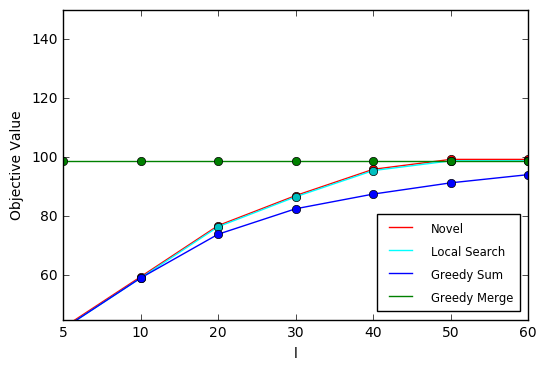

In [24]:
import matplotlib.pyplot as plt

ax = plt.subplot(111)

# http://matplotlib.org/users/text_intro.html
ax.set_xlabel('l')
ax.set_ylabel('Objective Value')

plt.ylim(45,150)
plt.xlim(0,len(novSol)-1)
labels = [l for l in Lvalues]

x = [i for i in range(len(novSol))]


plt.xticks(x, labels)

plt.plot(novSol, c = 'red', label = 'Novel')
plt.plot(novSol, 'ro')

plt.plot(lsSol, c = 'cyan', label = 'Local Search')
plt.plot(lsSol, 'co')

plt.plot(gsSol, c = 'blue', label = 'Greedy Sum')
plt.plot(gsSol, 'bo')

plt.plot(gmSol, c = 'green', label = 'Greedy Merge')
plt.plot(gmSol, 'go')

# http://matplotlib.org/1.3.0/examples/pylab_examples/legend_demo.html
legend = ax.legend(loc='lower right')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('small')



plt.show()